In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
path = "allinputnet"
mtlibpath_prefix ="allinputnet_mtl"

Nx=512
Ny=512

Lx= 50
Ly= 50
T_end = 1
dt = 0.005

myubatch_size = 1024

input_to_defect_ratio_sqrt = 2
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|████████████████████████████████████████| 200/200 [00:08<00:00, 24.79it/s]


Unique Myus count	 131072
Max value of myu:	 148.08007547591558
Min value of myu:	 9.296976126440947
Unique values: [9.296976126440947, 13.231833004515654, 13.961764506207512, 14.496379530409845, 14.621214278851474, 14.68709796017585, 14.991189933886536, 15.001973060387657, 15.160050441990675, 15.410448976993873, 15.678101358104096, 15.81905329734739, 15.959473654789512, 16.156428046300153, 16.500819283484603, 16.8157599882693, 17.10493245358608, 17.15817548879435, 17.256406471717387, 17.558428138842032, 17.575480307075523, 17.645898209535144, 17.79792973792659, 17.926743656962135, 17.979875977705884, 18.09031746281222, 18.090650135832124, 18.0912241133829, 18.136049970608525, 18.194034986871852, 18.262563104388207, 18.283125828997125, 18.318525188998, 18.440662554703884, 18.72024861117751, 18.723388405983695, 18.845122954758892, 18.850128089094074, 18.911563304598964, 18.96695377727041, 19.017418309477275, 19.017958089851522, 19.050154403725298, 19.08677358306868, 19.107303827002365, 

In [4]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

In [5]:
norm = np.real(A_original) * np.imag(A_original)
module = np.abs(A_original)

aplusb = np.sqrt(module**2 + 2*norm)
aminusb = np.sqrt(module**2 - 2*norm)
aplusb[np.isnan(aplusb)] = 0
aminusb[np.isnan(aminusb)] = 0

a = (aplusb - aminusb)/2
b = (aplusb + aminusb)/2

base1 = (np.abs((a+b*1j)- A_original) / np.abs(A_original)) < 0.001
base2 = (np.abs((b+a*1j)- A_original) / np.abs(A_original))  < 0.001
base3 = (np.abs((-a-b*1j)- A_original) / np.abs(A_original)) < 0.001
base4 = (np.abs((-b-a*1j)- A_original) / np.abs(A_original))  < 0.001

np.sum(base1 | base2 | base3 | base4), np.sum(base1 | True)

(52428800, 52428800)

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

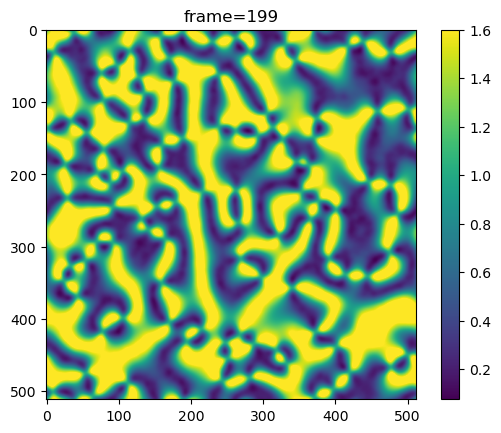

In [6]:
ploter = Plotter(np.real(A_norm))
ploter.output_animation(mem_rate, save_gif=True, file_name="original_A_real.gif")

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

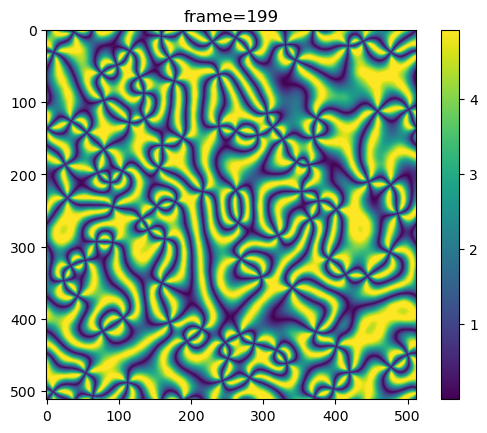

In [7]:
ploter = Plotter(a.squeeze())
ploter.output_animation(mem_rate, save_gif=True, file_name="4a.gif")

In [8]:
norm = np.real(A_original) * np.imag(A_original)
sqrdiff = (np.real(A_original)**2) - (np.imag(A_original)**2)

module = np.sqrt(np.sqrt(sqrdiff**2+4*(norm**2)))


aplusb = np.sqrt(module**2 + 2*norm)
aminusb = np.sqrt(module**2 - 2*norm)
aplusb[np.isnan(aplusb)] = 0
aminusb[np.isnan(aminusb)] = 0

a = (aplusb - aminusb)/2
b = (aplusb + aminusb)/2

# currently a > b, but for 

tmp = a[sqrdiff > 0].copy()
a[sqrdiff > 0] = b[sqrdiff > 0]
b[sqrdiff > 0] = tmp


base1 = (np.abs((a+b*1j)- A_original) / np.abs(A_original)) < 0.001
#base2 = (np.abs((b+a*1j)- A_original) / np.abs(A_original))  < 0.001
base3 = (np.abs((-a-b*1j)- A_original) / np.abs(A_original)) < 0.001
#base4 = (np.abs((-b-a*1j)- A_original) / np.abs(A_original))  < 0.001

np.sum(base1 | base3), np.sum(base1 | True)

(52428800, 52428800)

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

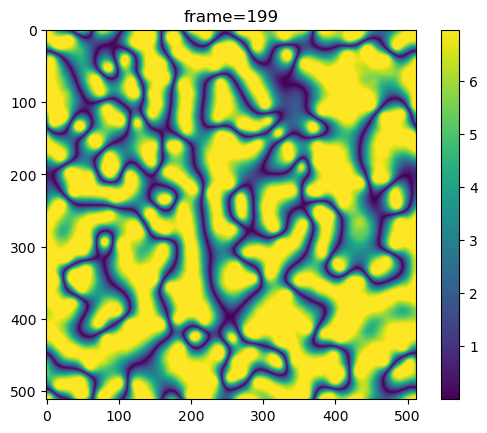

In [9]:
ploter = Plotter(a.squeeze())
ploter.output_animation(mem_rate, save_gif=True, file_name="2a.gif")